In [3]:
#!pip install stable-baselines
#Download and install ROMs
#!gdown -q http://www.atarimania.com/roms/Roms.rar
#!pip install -q unrar
#!mkdir ./roms_atari
#!unrar x Roms.rar ./roms_atari > /dev/null 2>&1
#!python -m atari_py.import_roms ./roms_atari > /dev/null 2>&1

In [2]:
from stable_baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
#from google.colab import drive
import gym.wrappers

(210, 160, 3)


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


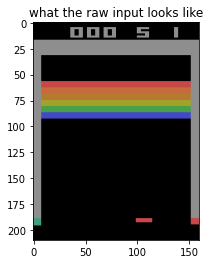

In [3]:
env = gym.make("BreakoutNoFrameskip-v4") #make_atari
obs = np.array(env.reset())
print(obs.shape)
plt.title("what the raw input looks like")
plt.imshow(obs)

(84, 84, 4)


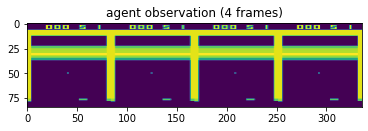

In [4]:
# Obseravtions (wrapped)
env = gym.make("BreakoutNoFrameskip-v4") #make_atari("BreakoutNoFrameskip-v4")
env = wrap_deepmind(env, frame_stack=True, scale=True)
obs = np.array(env.reset())

print(obs.shape)
plt.title("agent observation (4 frames)")
plt.imshow(obs.transpose([0, 2, 1]).reshape([env.observation_space.shape[0], -1]))

In [5]:
# Actions
print(env.action_space)
print(env.get_action_meanings())

Discrete(4)
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


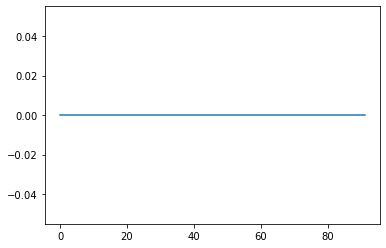

In [6]:
# Rewards
env.reset()
rewards = []
while True:
    obs, rew, done, info = env.step(env.action_space.sample())
    rewards.append(rew)
    if done:
        break
plt.plot(rewards)

In [7]:
num_actions = 4
def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))

    layer1 = layers.Conv2D(16, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(32, 4, strides=2, activation="relu")(layer1)
    #layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
    layer3 = layers.Flatten()(layer2)
    layer4 = layers.Dense(256, activation="relu")(layer3)
    action = layers.Dense(num_actions, activation="linear")(layer4)

    return keras.Model(inputs=inputs, outputs=action)

# The first model makes the predictions for Q-values which are used to make a action.
model = create_q_model()
# Target model
model_target = create_q_model()
model.summary()

Metal device set to: Apple M1 Max
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 16)        4112      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          8224      
_________________________________________________________________
flatten (Flatten)            (None, 2592)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               663808    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 677,172
Trainable params: 677,172
Non-trainable params: 0
_____________________

2022-06-17 13:16:01.510090: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-17 13:16:01.510296: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
gamma = 0.99  # Discount factor for past rewards

# Setting epsilon decay parameters
epsilon = 1.0  
epsilon_max_1 = 1.0 
epsilon_min_1 = 0.2  
epsilon_max_2 = epsilon_min_1  
epsilon_min_2 = 0.1
epsilon_max_3 = epsilon_min_2  
epsilon_min_3 = 0.02

epsilon_interval_1 = (epsilon_max_1 - epsilon_min_1)  
epsilon_interval_2 = (epsilon_max_2 - epsilon_min_2)  
epsilon_interval_3 = (epsilon_max_3 - epsilon_min_3)  

# Number of frames for exploration
epsilon_greedy_frames = 1000000.0

# Number of frames to take random action and observe output
epsilon_random_frames = 50000

# Maximum Replay Buffer volume
max_memory_length = 190000

# Size of batch taken from replay buffer
batch_size = 32  
max_steps_per_episode = 10000

# Train the model after 20 actions
update_after_actions = 20

# How often to update the target network
update_target_network = 10000

# In the Deepmind paper they use RMSProp however then Adam optimizer improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Using huber loss for stability
loss_function = keras.losses.Huber()

In [10]:
# Saving the model
#model_name = 'breakout_model_1'
#path = F"/content/gdrive/MyDrive/models/{model_name}" 
#model.save(path)

# Loading the model
# model = tf.keras.models.load_model(path)
def save_model(episode):
    model_name = f'breakout_beta_progress_episodes_{episode}.44'
    path = f"./{model_name}"
    model.save(path)

In [ ]:
# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []

episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

MAX_EPISODES = 50000

while True and episode_count < MAX_EPISODES:  # Run until solved
    state = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        if frame_count < epsilon_greedy_frames:
          epsilon -= epsilon_interval_1 / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min_1)
        
        if frame_count > epsilon_greedy_frames and frame_count < 2 * epsilon_greedy_frames:
          epsilon -= epsilon_interval_2 / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min_2)
        
        if frame_count > 2 * epsilon_greedy_frames:
          epsilon -= epsilon_interval_3 / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min_3)
          

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every 20th frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}, epsilon {:.3f}, loss {:.5f}"
            print(template.format(running_reward, episode_count, frame_count, epsilon, loss))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 18:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        save_model(episode_count)
        break
        
    # save model
    if episode_count % 5000 == 0:
        save_model(episode_count)
    

2022-06-17 13:17:14.125648: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-17 13:17:14.125881: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-17 13:17:14.177784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


running reward: 0.10 at episode 90, frame count 10000, epsilon 0.992, loss 0.01734
running reward: 0.05 at episode 186, frame count 20000, epsilon 0.984, loss 0.01653
running reward: 0.02 at episode 288, frame count 30000, epsilon 0.976, loss 0.03171
running reward: 0.07 at episode 382, frame count 40000, epsilon 0.968, loss 0.00013
running reward: 0.17 at episode 460, frame count 50000, epsilon 0.960, loss 0.00016
running reward: 0.12 at episode 545, frame count 60000, epsilon 0.952, loss 0.00019
running reward: 0.16 at episode 633, frame count 70000, epsilon 0.944, loss 0.00033
running reward: 0.13 at episode 719, frame count 80000, epsilon 0.936, loss 0.00030
running reward: 0.12 at episode 807, frame count 90000, epsilon 0.928, loss 0.00017
running reward: 0.05 at episode 904, frame count 100000, epsilon 0.920, loss 0.00007
running reward: 0.06 at episode 997, frame count 110000, epsilon 0.912, loss 0.00019
running reward: 0.13 at episode 1082, frame count 120000, epsilon 0.904, lo

2022-06-17 13:51:04.754545: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


running reward: 0.25 at episode 5045, frame count 570000, epsilon 0.544, loss 0.00024
running reward: 0.32 at episode 5113, frame count 580000, epsilon 0.536, loss 0.00011
running reward: 0.32 at episode 5192, frame count 590000, epsilon 0.528, loss 0.00223
running reward: 0.19 at episode 5272, frame count 600000, epsilon 0.520, loss 0.00025
running reward: 0.23 at episode 5354, frame count 610000, epsilon 0.512, loss 0.00016
running reward: 0.11 at episode 5442, frame count 620000, epsilon 0.504, loss 0.00160
running reward: 0.13 at episode 5527, frame count 630000, epsilon 0.496, loss 0.00028
running reward: 0.26 at episode 5605, frame count 640000, epsilon 0.488, loss 0.00050
running reward: 0.27 at episode 5685, frame count 650000, epsilon 0.480, loss 0.00183
running reward: 0.11 at episode 5777, frame count 660000, epsilon 0.472, loss 0.00031
running reward: 0.16 at episode 5857, frame count 670000, epsilon 0.464, loss 0.00040
running reward: 0.18 at episode 5937, frame count 6800